# Energinet Current Electicity Generation

Scrapes electricity generation and usage data data from [https://energinet.dk/](https://energinet.dk/)

Load modules, selenium is used for rendering and requires a WebDriver.
Download [http://chromedriver.chromium.org/](chromedriver) or [https://github.com/mozilla/geckodriver/releases](geckodriver)

Explores data as well as exporting to CSV file,and sending to a Slack Channel

In [3]:
import os
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup as bs
from selenium import webdriver
from time import sleep
import datetime
from selenium.webdriver.chrome.options import Options
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML

options = Options()
options.add_argument("--headless")
options.add_argument("--disable-gpu")
sns.set_palette(sns.cubehelix_palette(8, start=.5, rot=-.75))

Load web page and use Beautiful soup to parse. Store vales in pandas dataframe.

In [12]:
power = []
url = 'https://energinet.dk/'
tags = ["STØRRE VÆRKER OVER 100 MW", "MINDRE ANLÆG UNDER 100 MW", "VINDMØLLER", \
        "SOLCELLER", "NETTOUDVEKSLING IMPORT", "ELFORBRUG", "CO2-UDLEDNING"]
driver = webdriver.Chrome(options=options, \
        executable_path="C:\\Users\\rpe\\AppData\\Local\\Chromedriver\\chromedriver.exe")
driver.get(url)
sleep(4)
data = driver.page_source
soup = bs(data, 'html.parser')
driver.close()

for tag in tags:
    item = soup.find(text=tag)
    b_tag = item.parent
    next_td_tag = b_tag.findNext('span')
    value = next_td_tag.contents[0]
    power.append([tag, int(value.split(" ")[0].replace(".", "")), 
                  value.split(" ")[1], datetime.datetime.now().strftime("%Y-%m-%d %H:%M")])

df = pd.DataFrame.from_records(power, columns=['Source', 'Amount', 'Units', 'Timestamp'])
df["Amount"] = pd.to_numeric(df["Amount"])
df = df.set_index("Source", drop = False)

Print dataframe

In [13]:
display(HTML(df.to_html()))
print("Number of lines: {}".format(df.shape[0]))

,Source,Amount,Units,Timestamp
Source,,,,
STØRRE VÆRKER OVER 100 MW,STØRRE VÆRKER OVER 100 MW,994,MW,2019-03-26 15:15
MINDRE ANLÆG UNDER 100 MW,MINDRE ANLÆG UNDER 100 MW,610,MW,2019-03-26 15:15
VINDMØLLER,VINDMØLLER,1531,MW,2019-03-26 15:15
SOLCELLER,SOLCELLER,292,MW,2019-03-26 15:15
NETTOUDVEKSLING IMPORT,NETTOUDVEKSLING IMPORT,741,MW,2019-03-26 15:15
ELFORBRUG,ELFORBRUG,4168,MW,2019-03-26 15:15
CO2-UDLEDNING,CO2-UDLEDNING,204,g/kWh,2019-03-26 15:15


Number of lines: 7


Bar chart of energy sources

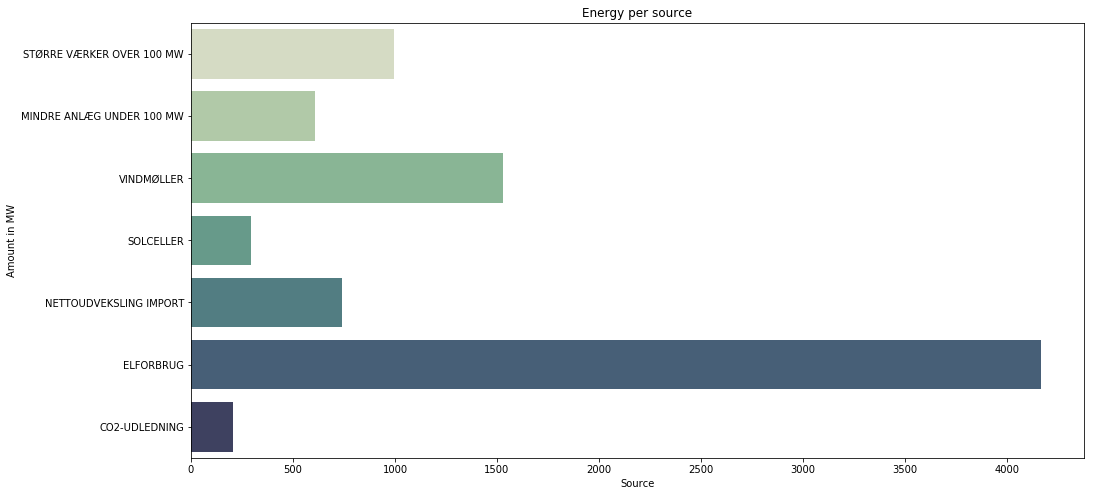

In [14]:
plt.rcParams["figure.figsize"] =(16,8)
ax = sns.barplot(y="Source", x="Amount", data=df[~df["Source"].isin(['CO2-udledning'])])
ax.set_ylabel('Amount in MW')
ax.set_xlabel('Source')
ax.set_title("Energy per source") 
plt.show()

Pie chart of Energy Production

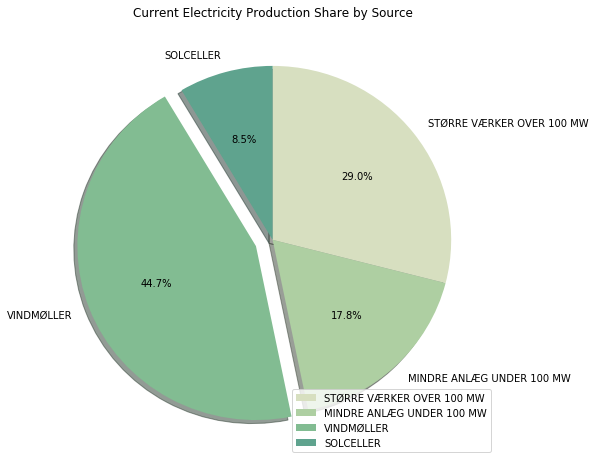

In [16]:
plt.rcParams["figure.figsize"] =(8,8)
filter_rows = ['NETTOUDVEKSLING IMPORT','ELFORBRUG','CO2-UDLEDNING']
df_filtered = df.filter(items=['Source', 'Amount'])
df_filtered =df_filtered[~df_filtered["Source"].isin(filter_rows)]

labels = df_filtered["Source"]
values = df_filtered["Amount"]
explode = [0, 0, 0.1, 0]
plt.pie(values,explode=explode, labels=labels,counterclock=False, shadow=True, autopct='%1.1f%%', startangle=90)
plt.title('Current Electricity Production Share by Source')
plt.legend(labels,loc=4)
plt.show()

Summary of wind and solar share of enegy consumption

In [19]:
df1 = df.set_index("Source", drop = False)
usage = df1.loc["ELFORBRUG","Amount"]
demand = "Current electricity demand in Denmark is {:,} MW".format(usage)
wind = "Windpower currently produces {:,} MW or {:.2%} of demand".format(df1.loc["VINDMØLLER","Amount"],df1.loc["VINDMØLLER","Amount"]/usage)
solar = "Solarcells currently produce {:,} MW or {:.2%} of demand".format(df1.loc["SOLCELLER","Amount"],df1.loc["SOLCELLER","Amount"]/usage)
print(demand)
print(wind)
print(solar)                                   

Current electricity demand in Denmark is 4,168 MW
Windpower currently produces 1,531 MW or 36.73% of demand
Solarcells currently produce 292 MW or 7.01% of demand


Send data to Slack Channel by importing SlackMessaging notebook

In [20]:
%run SlackMessaging.ipynb
slack_post(demand + ":electric_plug:\n" + wind + ":wind_blowing_face:\n" + solar + ":sunny:")

'Data sent successfully'

Save data to csv, append to file it it already exists

In [21]:
file_name = "energinet.csv"
if os.path.exists(file_name):
    with open(file_name, 'a', encoding='utf-8') as f:
        df.to_csv(f, header=False, sep=";", index=False)
else:
    df.to_csv(path_or_buf=file_name, header=True, sep=";", index=False)

df.to_csv(sep=";")

'Source;Source;Amount;Units;Timestamp\nSTØRRE VÆRKER OVER 100 MW;STØRRE VÆRKER OVER 100 MW;994;MW;2019-03-26 15:15\nMINDRE ANLÆG UNDER 100 MW;MINDRE ANLÆG UNDER 100 MW;610;MW;2019-03-26 15:15\nVINDMØLLER;VINDMØLLER;1531;MW;2019-03-26 15:15\nSOLCELLER;SOLCELLER;292;MW;2019-03-26 15:15\nNETTOUDVEKSLING IMPORT;NETTOUDVEKSLING IMPORT;741;MW;2019-03-26 15:15\nELFORBRUG;ELFORBRUG;4168;MW;2019-03-26 15:15\nCO2-UDLEDNING;CO2-UDLEDNING;204;g/kWh;2019-03-26 15:15\n'